```{include} ../math-definitions.md
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from statsmodels.tsa.api import VAR

np.random.seed(1995)

# Estimación

## Especificación de un VAR

Para especificar un VAR, hay dos cosas que escoger:
1. Las $n$ series que conforman el VAR
2. El número $p$ de rezagos a ser incluidos en el modelo

En contraste con la metodología de Box-Jenkins, el modelo VAR no es parsimonioso $\Rightarrow$ un VAR está sobreparametrizado:

-  hay $n + pn^2$ parámetros.
-  muchos de sus coeficientes no son significativos
-  regresores posiblemente son altamente colineales, estadísticos $t$ no confiables.

No obstante, en un VAR los coeficientes individuales no son de interés. Interesa determinar la dinámica del modelo (impulso respuesta) y la causalidad (Granger, que estudiaremos en la siguiente sección).



## Estimación de un VAR

El VAR reducido es un sistema de ecuaciones SUR, donde todas las ecuaciones tienen los mismos regresores.

Por lo tanto, la estimación OLS ecuación por ecuación es insesgada, eficiente y consistente.


La matriz de covarianza de los errores se estima a partir de los residuos
\begin{equation*}
\hat{\Omega} =\frac{1}{T-np-1}\sum_{t=1}^{T}\hat{\epsilon_t}\hat{\epsilon_t}'
\end{equation*}




## Estimación de un VAR no estacionario
Si las series son I(1), ¿hay que diferenciarlas para estimar el VAR? Hay un debate respecto:

```{panels}
:header: bg-danger text-center text-white

NO:
^^^
Algunos aconsejan no diferenciar las series, porque se pierde información, alegando que la meta del VAR es determinar relaciones entre variables, no los parámetros mismos.

---
:header: bg-success text-center text-white

SÍ:
^^^
Otros advierten que si las series son integradas, el VAR en niveles no es consistente con el proceso generador de datos. En este caso se aconseja estudiar la cointegración de las series $\Rightarrow$ VECM
```


{{ empieza_ejemplo }} Propiedades de la estimación OLS de un VAR estacionario {{ fin_titulo_ejemplo }}

En este ejemplo simulamos realizaciones del VAR(1)
\begin{align*}
x_t &= 0.8x_{t-1} + 0.7y_{t-1} + \epsilon_{x,t} \\
y_t &= -0.2x_{t-1} + 0.5y_{t-1} + \epsilon_{y,t}
\end{align*}

que puede escribirse
\begin{align*}
\notation{\begin{pmatrix}x_t \\ y_t\end{pmatrix}}{$Y_t$} &=
\notation{\begin{pmatrix}0.8 & 0.7 \\ -0.2 & 0.5\end{pmatrix}}{$\Phi$}
\notation{\begin{pmatrix}x_{t-1} \\ y_{t-1}\end{pmatrix}}{$Y_{t-1}$} +
\notation{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\end{pmatrix}}{$\epsilon_t$}
\\ \\
\Omega &= \begin{pmatrix}0.9 & 0 \\ 0 & 0.9\end{pmatrix}
\end{align*}

y las utilizamos para estimar los párametros originales por OLS. El objetivo es ilustrar que este estimador está insesgado y que es consistente.

In [2]:
# Funciones auxiliares:
# Definimos las matrices de parámetros $\Phi$ y $\Omega$. Declaramos dos funciones: para simular una muestra de observaciones del VAR, y otra para estimar los coeficientes de $\Phi$ a partir de tales simulaciones.


Φ = np.array([[0.8, 0.7], [-0.2, 0.5]])
param_names = ['$Φ_{11}$', '$Φ_{21}$', '$Φ_{12}$', '$Φ_{22}$']
sigma = 0.9

def var_sample(T = 100):
    ''' Simula el VAR(1) T períodos'''
    Y = np.zeros((T,2))
    for t in range(1, T):
        Y[t] = Y[t-1] @ Φ.T + sigma * np.random.randn(2) # transpuesta es más rápido

    return pd.DataFrame(Y, columns=['x', 'y'])

def Φ_ols(data):
    '''Estima un VAR(1) a partir de datos, retorna coeficientes como vector'''
    return VAR(data).fit().coefs[0].flatten()

{bdg-primary}`La estimación OLS de un VAR es insesgada`

Con un experimento de Monte Carlo obtenemos 10000 muestras de $T=100$ observaciones del VAR. Para cada muestra estimamos el VAR y colectamos los coeficientes estimados.

In [3]:
%%time
nrepetitions = 10_000
estimates = pd.DataFrame(
     [Φ_ols(var_sample()) for _ in range(nrepetitions)],                         columns=param_names)

estimates.head()

CPU times: total: 33.5 s
Wall time: 33.5 s


,$Φ_{11}$,$Φ_{21}$,$Φ_{12}$,$Φ_{22}$
0,0.691685,0.679327,-0.276123,0.428017
1,0.779543,0.763695,-0.186702,0.584590
2,0.827301,0.837952,-0.278445,0.444311
3,0.826135,0.791333,-0.343680,0.382260
4,0.819778,0.615994,-0.153597,0.315891


Luego graficamos la distribución de cada columna (estimaciones de uno de los parámetros) con un histograma. Observe cómo la distribución estimada está centrada alrededor del verdadero parámetro en cada uno de los gráficos.

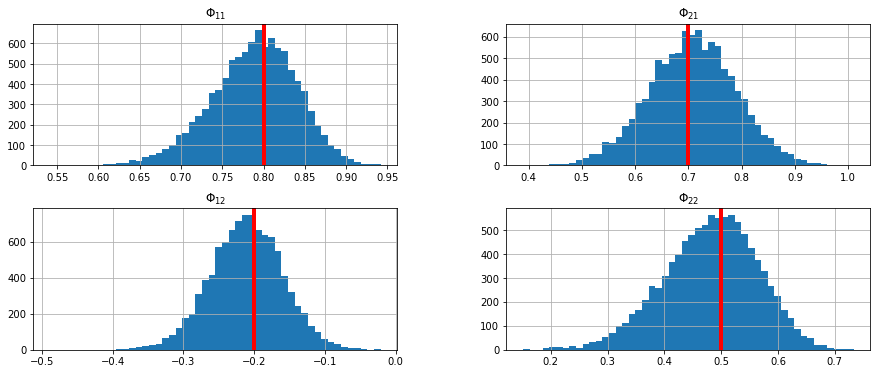

In [4]:
ax = estimates.hist(bins=50,figsize=[15,6])

for i in range(2):
    for j in range(2):
        ax[i,j].axvline(x=Φ[i,j],linewidth=4, color='r')

{bdg-primary}`La estimación OLS de un VAR es consistente`

Para ilustrar que la estimación OLS de un VAR es consistente, simulamos una sola muestra de datos y vamos agregando una nueva observación. En cada paso estimamos el VAR con OLS. Observe que conforme aumenta el número de observaciones, los valores estimados convergen a los parámetros poblacionales.

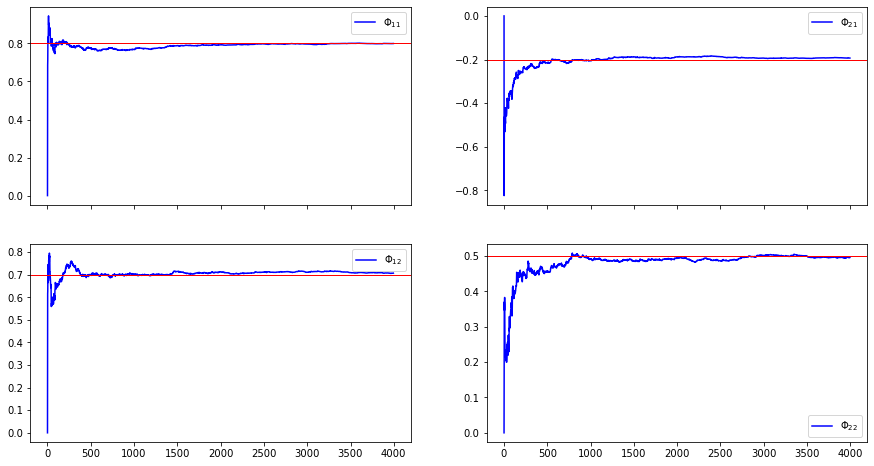

In [5]:
xlag = np.zeros([2,1])
XpX = np.zeros([2,2])
XpY = np.zeros([2,2])

T = 4000
minT = 5
Xest = np.zeros([T+1, 4])

for t in range(T+1):
    x = Φ @ xlag + sigma * np.random.randn(2,1)
    XpX += np.outer(xlag, xlag)
    XpY += np.outer(xlag, x)
    xlag = x.copy()

    if t>minT:
        Xest[t] = np.linalg.solve(XpX/t, XpY/t).flatten()


estimates2 = pd.DataFrame(Xest[minT:], columns=param_names)

ax = estimates2.plot(color='b',figsize=[15,8],subplots=True, layout=[2,2])

for i in range(2):
    for j in range(2):
        ax[i,j].axhline(y=Φ[j,i],linewidth=1, color='r')

{{ termina_ejemplo }}



## Escogiendo el óptimo número de rezagos del VAR

La selección del número de rezagos $p$ es crítica.

```{panels}
:header: bg-danger text-center text-white

Si $p$ es demasiado pequeño
^^^
el modelo está mal especificado

---
Si $p$ es demasiado grande
^^^
se desperdician grados de libertad y se introduce colinealidad.
```

Una opción: dejar que $p$ difiera para cada ecuación y variable $\Rightarrow$ el VAR no podría estimarse con OLS.

Por tanto, se determina un sólo $p$ para todas las variables y ecuaciones, usando dos enfoques distintos
-  Descartando los últimos rezagos si no son significativos
-  Utilizando un criterio de selección que contraponga el ajuste a los grados de libertad.


## Escogiendo el $p$ óptimo con pruebas de significancia

Suponga que queremos decidir entre $p$ y $q$ número de rezagos, con $q<p$.

Obtenemos $\hat{\Omega}$ para ambos modelos, **usando la misma muestra**.

Comprobamos la significancia conjunta de los rezagos $q+1,\dots,p$ con la prueba de razón de verosimilitud
\begin{equation*}
(T-1-pn)\left(\ln\left|\hat{\Omega}_q\right| - \ln\left|\hat{\Omega}_p\right|\right) \overset{asym}{\sim} \chi^2(n^2(p-q))
\end{equation*}

Si no se rechaza la hipótesis nula, puede escogerse $q$ rezagos.

Limitaciones:
-  Resultado asintótico, pero muestras  usualmente pequeñas
-  Resultado sensible a escogencia de $p$ y $q$.



## Escogiendo el $p$ óptimo con criterios de selección

En la práctica, el número óptimo de rezagos se escoge minimizando el valor de AIC o de SBC:
\begin{align*}
\text{AIC} &= T\ln\left|\hat{\Omega}\right| + 2N \\
\text{SBC} &= T\ln\left|\hat{\Omega}\right| + N\ln T \\
\end{align*}
donde $N=n^2p+n$ es el número total de parámetros estimados

Rezagos adicionales reducen $\hat{\Omega}$, pero incrementando $N$






## Usando un VAR para describir los datos

La práctica usual en el análisis VAR es reportar
-  pruebas de causalidad de Granger
-  funciones de impulso respuesta
-  descomposición de varianza del error de pronóstico

Usualmente no se reportan los coeficientes estimados ni el $R^2$, porque no son tan informativos.


## Causalidad de Granger

Las pruebas de causalidad de Granger determinan si los valores rezagados de una variable ayudan a predecir otra variable.
-  Si los rezagos de $A$ no ayudan a predecir $B$, entonces coeficientes de los rezagos de $A$ en la ecuación de $B$ son ceros.
-  Si alguna variable no es causada en el sentido de Granger por ninguna otra, **no implica que la variable sea exógena**. Bien podría haber causalidad contemporánea.



{{ empieza_ejemplo }} Causalidad de Granger {{ fin_titulo_ejemplo }}


En el modelo VAR(2) con variables $y_t, m_t$:

\begin{equation*}
\begin{aligned}
y_t &= c^y + \alpha_{11}y_{t-1} + \alpha_{12}m_{t-1} + \beta_{11}y_{t-2} + \beta_{12}m_{t-2} + u^y_t\\
m_t &= c^m + \alpha_{21}y_{t-1} + \alpha_{22}m_{t-1} + \beta_{21}y_{t-2} + \beta_{22}m_{t-2} + u^m_t
\end{aligned}
\end{equation*}

las pruebas de causalidad de Granger son:

| Hipótesis nula    | Restricciones                  |
| :---------------- | :----------------------------- |
| $m$ no causa $y$  | $\alpha_{12} = \beta_{12} = 0$ |
| $y$ no causa $m$  | $\alpha_{21} = \beta_{21} = 0$ |


Si se rechaza, por ejemplo, la primera hipótesis, decimos que **$m$ causa $y$ en el sentido de Granger**.
{{ termina_ejemplo }}